In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, trange

In [2]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
df = pd.read_csv("../data/interim/small_10000_orders_weighted_adjacency_matrix.csv")
# df = df.sample(500)
df["rating"] = df.weight

5 Most Purchased Products:
       product_id  weight
3169        13176    1307
5904        24852    1305
5228        21903     963
5032        21137     861
11221       47209     785


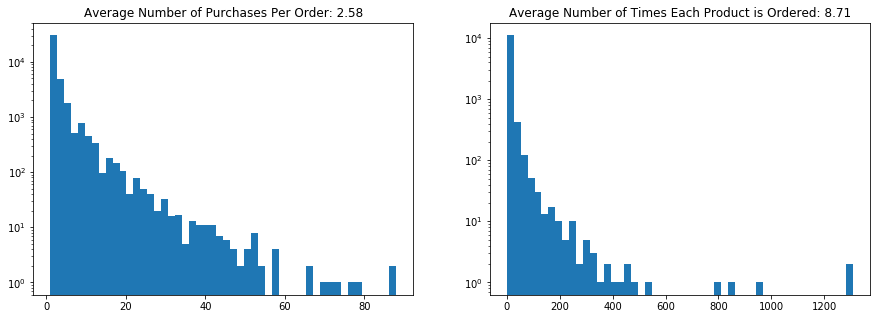

In [4]:
df_grouped = df[["product_id", "weight"]].groupby(["product_id"]).sum()
df_grouped.reset_index(inplace=True)
print(
    f"5 Most Purchased Products:\n{df_grouped.sort_values(by='weight', ascending=False).head(5)}"
)

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
ax1.hist(df.weight, bins=50)
ax1.set_yscale("log")
ax1.set_title(f"Average Number of Purchases Per Order: {df.weight.mean():.2f}")

ax2.hist(df_grouped.weight, bins=50)
ax2.set_title(
    f"Average Number of Times Each Product is Ordered: {df_grouped.weight.mean():.2f}"
)
ax2.set_yscale("log")

plt.show()

## Collaborative Filtering

For the models we will want to use a numeric index rather than the product_id and user_id so that we can easily match the embedding vector with the user or product.

In [5]:
# prod_sets = product_sets(df)

# id_u_dict = list_to_indexed_dict(df.user_id)
# id_p_dict = list_to_indexed_dict(df.product_id)

# u_dict = {key: val for val, key in id_u_dict.items()}
# p_dict = {key: val for val, key in id_p_dict.items()}
# w_dict = {val: 1 for val in df.weight.unique()}

# num_prods = len(p_dict)
# num_negs = 5
# idx = 5

# df_s = df.sample(20)
# user_ids = df_s["user_id"].iloc[10]


# def negative_sampling(num_negs, user_ids, prod_sets, p_dict, u_dict):
#     """
#     Draw negative samples for each of the positive interactions.
#     """
#     if isinstance(user_ids, np.int64):
#         user_ids = [user_ids]

#     u_list = []
#     p_list = []
#     r_list = num_negs * len(user_ids) * [0.]

#     for u_id in user_ids:
#         neg_set = set(p_dict.keys()) - prod_sets[u_id]
#         neg_v = np.random.choice(tuple(neg_set), num_negs) 

#         for p_id in neg_v:
#             u_list.append(u_dict[u_id])
#             p_list.append(p_dict[p_id])

#     return (torch.tensor(u_list), torch.tensor(p_list), torch.tensor(r_list))

# u_samp = torch.from_numpy(pd.Series(df_s["user_id"].iloc[:10]).map(u_dict).to_numpy())
# p_samp = torch.from_numpy(pd.Series(df_s["product_id"].iloc[:10]).map(p_dict).to_numpy())
# w_samp = torch.from_numpy(pd.Series(df_s["rating"].iloc[:10]).map(w_dict).to_numpy()).float()

# negative_sampling(num_negs, user_ids, prod_sets, p_dict, u_dict)

In [6]:
def product_sets(df):
    """
    Generate sets for each user containing products that 
    they have previously purchased.
    
    Args:
        df (pandas DataFrame): Dataframe containing user_id and
            product_id columns.
    Return:
        dictionary with user_id as keys and the product sets as values.
    """
    df_g = (
        df[["user_id", "product_id"]]
        .groupby(["user_id"])["product_id"]
        .agg(lambda x: set([val for val in x]))
    )
    df_g = df_g.reset_index()
    df_g.columns = ["user_id", "product_list"]

    return df_g.set_index("user_id").to_dict()["product_list"]


def list_to_indexed_dict(list_):
    """
    Assign id to distinct list elements and return 
    the id -> element mapping as a dictionary.
    """
    return dict(enumerate(sorted(set(list_))))


class RatingsDataset(Dataset):
    """
    User, product, ratings dataset. 
    """

    def __init__(
        self,
        dataframe,
        product_dict,
        user_dict,
        dev=torch.device("cpu"),
        reweighting=dict(),
        num_negs=0,
    ):
        """
        Args:
            dataframe (pandas.DataFrame): Dataframe containing ratings.
            product_dict (dict): Dictionary mapping product ids to indices.
            user_dict (dict): Dictionary mapping user ids to indices.
            reweighting (dict, optional): Dictionary mapping ratings to new values.
            dev (torch device): Hardware that the model should run on.
        """
        super(RatingsDataset, self).__init__()

        if num_negs < 0:
            raise ValueError("The number of negative samples must be positive.")

        self.df = dataframe
        self.prod_sets = product_sets(dataframe)
        self.p_dict = product_dict
        self.u_dict = user_dict
        self.w_dict = reweighting
        self.num_prods = len(product_dict)
        self.num_users = len(user_dict)
        self.dev = dev
        self.num_negs = num_negs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        Get and return Tensor for item, user, ratings triplet
        """
        user_ids = self.df["user_id"].iloc[idx]
        item = self.transform(self.df["product_id"].iloc[idx], self.p_dict)
        user = self.transform(user_ids, self.u_dict)
        rating = self.transform(self.df["rating"].iloc[idx], self.w_dict).float()

        if self.num_negs:
            neg_i, users, neg_r = self.negative_sampling(user_ids)

            item = torch.cat((item, neg_i))
            user = torch.cat((user, users))
            rating = torch.cat((rating, neg_r))

        return (item, user, rating)

    def transform(self, df_rows, mapping):
        """
        Replace dataframe with index values and convert to torch.Tensor
        """
        transformed = pd.Series(df_rows).replace(mapping).to_numpy()

        return torch.from_numpy(transformed).to(self.dev)

    def negative_sampling(self, user_ids):
        """
        For each user interaction randomly sample products that they
        have not previously purchased.
        """
        if isinstance(user_ids, np.int64):
            user_ids = [user_ids]

        u_list = []
        p_list = []
        r_list = self.num_negs * len(user_ids) * [0.0]

        for u_id in user_ids:
            neg_set = set(self.p_dict.keys()) - self.prod_sets[u_id]
            neg_v = np.random.choice(tuple(neg_set), self.num_negs)

            for p_id in neg_v:
                u_list.append(self.u_dict[u_id])
                p_list.append(self.p_dict[p_id])

        return (torch.tensor(p_list), torch.tensor(u_list), torch.tensor(r_list))


def dataframe_split(df, train_frac=0.80, test_frac=0.10):
    """
    Split dataframe into training, testing, and validation sets.
    """
    train_df = df.sample(frac=train_frac, random_state=23)
    test_df = df.drop(train_df.index).sample(int(test_frac * len(df)), random_state=23)
    # All samples not in test or train sets are used for validation
    val_df = df.drop(pd.concat([train_df, test_df], axis=0).index)

    return train_df, val_df, test_df


class MatrixFactorization(torch.nn.Module):
    """Matrix factorization using pytorch."""

    def __init__(self, n_users, n_products, n_factors=20):
        """
        Initalize the user and product embedding vectors in latent space.
        
        Args:
            n_users (int): Number of users with prior purchases.
            n_products (int): Total number of products purchased.
            n_factors (integer, optional): Dimension of the latent embedding space.
        """
        super(MatrixFactorization, self).__init__()

        self.user_factors = nn.Embedding(n_users, n_factors)
        self.product_factors = nn.Embedding(n_products, n_factors)
        self.user_bias = nn.Embedding(n_users, 1)
        self.product_bias = nn.Embedding(n_products, 1)

    def forward(self, user, item):
        """ 
        Matrix multiplication between user and product 
        embedding vectors.
        """
        prediction = self.user_bias(user).squeeze() + self.product_bias(item).squeeze()
        prediction += (
            ((self.user_factors(user)) * (self.product_factors(item))).sum(2).squeeze()
        )

        return prediction

    def prediction(self, user, item):
        """
        Use product and user embedding vectors to calculate
        a probability for positive interaction.
        """
        activation = nn.Sigmoid()
        prediction = self.user_bias(user).squeeze() + self.product_bias(item).squeeze()
        prediction += (
            ((self.user_factors(user)) * (self.product_factors(item))).sum(2).squeeze()
        )
        predict_pos = activation(prediction)
        predict_neg = 1 - predict_pos

        return torch.stack((predict_neg, predict_pos)).argmax(0).float()

    def compute_loss(self, loss_fn, item, user, rating):
        """Calculate the loss of the predicted ratings."""
        return loss_fn(self.forward(user, item), rating.float().squeeze())

    def compute_accuracy(self, data_loader):
        """
        Compute the accuracy of our predictions against the true ratings.
        """
        correct = 0
        total = 0

        self.eval()
        with torch.no_grad():
            for item, user, true_rating in data_loader:
                predicted = self.prediction(user, item)
                total += predicted.numel()
                correct += (predicted == true_rating).sum().item()

        return total, correct

In [12]:
# here we are only taking 500 interactions
df_use = df.sample(100)
num_negs = 15

train_df, val_df, test_df = dataframe_split(
    df_use
)
index_to_product_dict = list_to_indexed_dict(df_use.product_id)
index_to_user_dict = list_to_indexed_dict(df_use.user_id)

product_to_index_dict = {key: value for value, key in index_to_product_dict.items()}
user_to_index_dict = {key: value for value, key in index_to_user_dict.items()}
reweight_dict = {val: 1.0 for val in df_use.weight.unique()}

n_users, n_products = len(user_to_index_dict), len(product_to_index_dict)

train_data = RatingsDataset(
    train_df,
    product_to_index_dict,
    user_to_index_dict,
    reweighting=reweight_dict,
    dev=dev,
    num_negs=num_negs,
)
val_data = RatingsDataset(
    val_df,
    product_to_index_dict,
    user_to_index_dict,
    reweighting=reweight_dict,
    dev=dev,
    num_negs=num_negs,
)
test_data = RatingsDataset(
    test_df,
    product_to_index_dict,
    user_to_index_dict,
    reweighting=reweight_dict,
    dev=dev,
    num_negs=num_negs,
)

In [21]:
bs = 50
epochs = 100
print_every = 5
embedding_dim = 10
l2_penalty = 0.001
learning_rate = 1e-6

train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_data, batch_size=bs)
test_loader = DataLoader(test_data, batch_size=bs)

model = MatrixFactorization(n_users, n_products, n_factors=embedding_dim)
model.to(dev)
# loss_fn = nn.MSELoss()
model.loss_fn = nn.BCEWithLogitsLoss()

model.optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, weight_decay=l2_penalty
)

In [ ]:
for epoch in trange(epochs):
    train_loss = 0

    model.train()
    train_loss = train(model, train_loader)

    model.eval()
    with torch.no_grad():
        val_loss = [
            model.compute_loss(loss_fn, item, user, rating).item()
            for item, user, rating in val_loader
        ]
    val_loss = np.sum(val_loss)
    val_total, val_correct = model.compute_accuracy(val_loader)

    if (epoch + 1) % print_every == 0:
        print(
            f"epoch #{epoch + 1}, training loss: {train_loss:0.3f}, "
            f"validation loss: {val_loss:0.3f}, "
            f"validation accuracy: {(100 * val_correct / val_total):.2f}"
        )

In [ ]:
sigmoid = nn.Sigmoid()
users_items = sigmoid(
    model.user_factors.weight @ model.product_factors.weight.transpose(0, 1)
)
values = users_items.detach().numpy()

plt.hist(values.ravel(), bins=50)
plt.show()

In [25]:
def train(model):
    """
    Train the model on the data generated by the dataloader.
    """
    train_loss = 0
    for item, user, rating in train_loader:
        model.optimizer.zero_grad()
        loss = model.compute_loss(model.loss_fn, item, user, rating)
        train_loss += loss.item()

        loss.backward()
        model.optimizer.step()

#     return train_loss

In [33]:
# This example comes directly from the documentation on torch.multiprocessing
import torch.multiprocessing as mp

bs = 50
epochs = 100
print_every = 5
embedding_dim = 10
l2_penalty = 0.001
learning_rate = 1e-6
num_processes = 48


train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_data, batch_size=bs)
test_loader = DataLoader(test_data, batch_size=bs)

model = MatrixFactorization(n_users, n_products, n_factors=embedding_dim)
model.to(dev)

# loss_fn = nn.MSELoss()
model.loss_fn = nn.BCEWithLogitsLoss()

model.optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate, weight_decay=l2_penalty
)

In [34]:
user_initial_weights = model.user_factors.weight.detach()
user_initial_weights

tensor([[-1.4333e+00, -8.9963e-01, -1.9330e-02, -1.7814e+00,  2.0324e-02,
         -4.1041e-01,  1.4695e+00, -2.3004e+00, -5.5006e-01,  9.6585e-01],
        [-1.4763e+00, -4.5092e-01,  9.0537e-01, -1.7011e+00,  1.7471e+00,
          1.2400e+00,  7.6806e-01, -7.3178e-01,  1.9154e-01, -1.6154e+00],
        [ 3.8457e-01, -6.9640e-01,  4.4247e-01,  8.9063e-01,  7.2175e-01,
          1.5651e-01,  5.6657e-01, -6.5262e-01,  5.3221e-01, -1.0787e+00],
        [-9.5290e-01,  3.6351e-02,  8.9709e-01,  2.3399e-01,  6.7542e-01,
         -8.4097e-01,  9.9748e-01, -1.3285e+00, -3.4416e-02,  5.0887e-01],
        [ 5.9784e-01, -9.0697e-01, -7.1282e-01, -2.4948e-01, -6.4971e-01,
          8.7206e-01, -5.8542e-01, -3.2919e-01, -3.4160e-01,  1.3576e-01],
        [-1.9971e-01,  1.5334e+00,  1.3532e+00,  1.1532e+00, -1.7517e+00,
         -8.9848e-01, -5.7436e-01,  2.4249e-01,  1.1253e+00,  1.1115e+00],
        [-1.9362e-01,  1.7086e+00,  2.7931e-01,  5.5493e-01, -9.6455e-01,
         -1.7386e+00,  2.4911e-0

In [35]:
# NOTE: this is required for the ``fork`` method to work
model.share_memory()
processes = []
for rank in range(num_processes):
    p = mp.Process(target=train, args=(model, ))
    p.start()
    processes.append(p)
for p in processes:
    p.join()

In [36]:
user_final_weights = model.user_factors.weight.detach()
user_final_weights

tensor([[-1.4333e+00, -8.9963e-01, -1.9330e-02, -1.7814e+00,  2.0324e-02,
         -4.1041e-01,  1.4695e+00, -2.3004e+00, -5.5006e-01,  9.6585e-01],
        [-1.4763e+00, -4.5092e-01,  9.0537e-01, -1.7011e+00,  1.7471e+00,
          1.2400e+00,  7.6806e-01, -7.3178e-01,  1.9154e-01, -1.6154e+00],
        [ 3.8457e-01, -6.9640e-01,  4.4247e-01,  8.9063e-01,  7.2175e-01,
          1.5651e-01,  5.6657e-01, -6.5262e-01,  5.3221e-01, -1.0787e+00],
        [-9.5290e-01,  3.6351e-02,  8.9709e-01,  2.3399e-01,  6.7542e-01,
         -8.4097e-01,  9.9748e-01, -1.3285e+00, -3.4416e-02,  5.0887e-01],
        [ 5.9784e-01, -9.0697e-01, -7.1282e-01, -2.4948e-01, -6.4971e-01,
          8.7206e-01, -5.8542e-01, -3.2919e-01, -3.4160e-01,  1.3576e-01],
        [-1.9971e-01,  1.5334e+00,  1.3532e+00,  1.1532e+00, -1.7517e+00,
         -8.9848e-01, -5.7436e-01,  2.4249e-01,  1.1253e+00,  1.1115e+00],
        [-1.9362e-01,  1.7086e+00,  2.7931e-01,  5.5493e-01, -9.6455e-01,
         -1.7386e+00,  2.4911e-0

In [37]:
user_initial_weights == user_final_weights

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],


In [ ]:
def recommend_item_for_user(model, user_id):
    """
    
    """
    m = model.eval().cpu()

    user_ids = torch.LongTensor([user2idx[u] for u in [user_id] * len(items)])
    item_ids = torch.LongTensor([item2idx[b] for b in items])

    remove = set(ratings[ratings[user_col] == user_id][item_col].values)

    preds = m(user_ids, item_ids).detach().numpy()
    pred_item = [
        (p, b) for p, b in sorted(zip(preds, items), reverse=True) if b not in remove
    ]

    return pred_item


def recommend_user_for_item(model, item_id):
    """
    
    """
    m = model.eval().cpu()

    user_ids = torch.LongTensor([user2idx[u] for u in users])
    book_ids = torch.LongTensor([item2idx[b] for b in [item_id] * len(users)])

    remove = set(ratings[ratings[item_col] == book_id][user_col].values)

    preds = m(user_ids, item_ids).detach().numpy()
    pred_user = [
        (p, u) for p, u in sorted(zip(preds, users), reverse=True) if u not in remove
    ]

    return pred_user